In [19]:
import xml.etree.ElementTree as ET
import pandas as pd

## load and parse XML
tree = ET.parse('export.xml')
root = tree.getroot()

# Extract all records
records = []
for record in root.findall('Record'):
    records.append(record.attrib)

df = pd.DataFrame(records)


In [20]:
df.head()
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803664 entries, 0 to 1803663
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   type           object
 1   sourceName     object
 2   sourceVersion  object
 3   unit           object
 4   creationDate   object
 5   startDate      object
 6   endDate        object
 7   value          object
 8   device         object
dtypes: object(9)
memory usage: 123.8+ MB


Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')

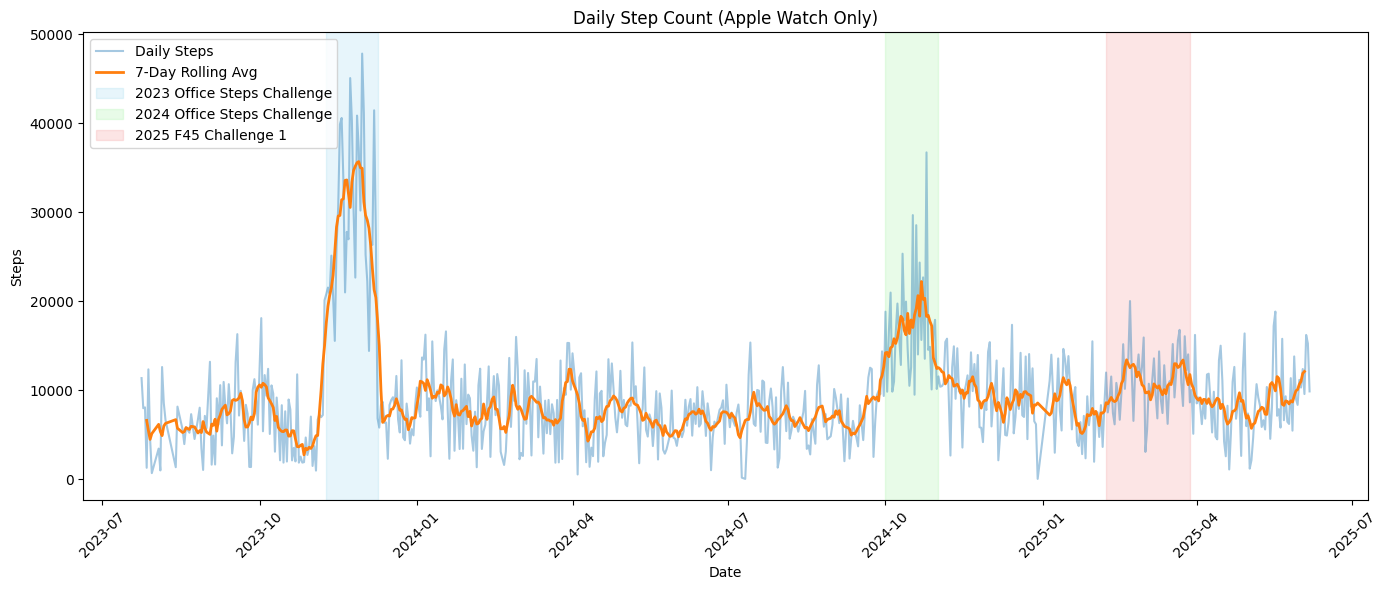

In [21]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# === Load XML ===
tree = ET.parse('export.xml')
root = tree.getroot()

# === Extract Step Count from Apple Watch ===
records = []
for record in root.findall('Record'):
    if (record.attrib['type'] == 'HKQuantityTypeIdentifierStepCount' and
        'Watch' in record.attrib.get('sourceName', '')):
        records.append({
            'value': float(record.attrib['value']),
            'startDate': pd.to_datetime(record.attrib['startDate']),
            'endDate': pd.to_datetime(record.attrib['endDate']),
            'source': record.attrib['sourceName']
        })

# === Create DataFrame ===
df_steps = pd.DataFrame(records)
df_steps['date'] = df_steps['startDate'].dt.date
daily_steps = df_steps.groupby('date')['value'].sum().reset_index()

# === Rolling Average ===
daily_steps['rolling_avg'] = daily_steps['value'].rolling(window=7, center=True).mean()

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(daily_steps['date'], daily_steps['value'], label='Daily Steps', alpha=0.4)
plt.plot(daily_steps['date'], daily_steps['rolling_avg'], label='7-Day Rolling Avg', linewidth=2)

# === Highlight Date Ranges ===
highlight_ranges = [
    ("2023-11-09", "2023-12-09", "2023 Office Steps Challenge", "skyblue"),
    ("2024-10-01", "2024-11-01", "2024 Office Steps Challenge", "lightgreen"),
    ("2025-02-07", "2025-03-28", "2025 F45 Challenge 1", "lightcoral")
]

for start_str, end_str, label, colour in highlight_ranges:
    start = pd.to_datetime(start_str)
    end = pd.to_datetime(end_str)
    plt.axvspan(start, end, color=colour, alpha=0.2, label=label)

# === Final Plot Settings ===
plt.title('Daily Step Count (Apple Watch Only)')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()



In [22]:
# List all unique sources for step count records
source_names = set()
for record in root.findall('Record'):
    if record.attrib['type'] == 'HKQuantityTypeIdentifierStepCount':
        source_names.add(record.attrib.get('sourceName'))

print(source_names)

## Needed to add condition that step count comes from watch only otherwise it is inflated by the phone records. 

{'Joshua’s iPhone', 'JB Watch'}


In [25]:
## I would like to explore the association between weather and my steps count.
## For ease of analysis, I will assume I was in Auckland for the whole period although there were times where I wasn't. 

## For this I will need Auckland weather data.
weather = pd.read_csv('auckland-weather-700.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])

# Optional cleanup
weather = weather[['datetime', 'temp', 'precip']]  # adapt to your column names

weather.describe()

,datetime,temp,precip
count,701,701.000000,701.000000
mean,2024-06-19 23:59:59.999999744,16.093153,2.932412
min,2023-07-06 00:00:00,7.800000,0.000000
25%,2023-12-28 00:00:00,13.500000,0.000000
50%,2024-06-20 00:00:00,16.100000,0.200000
75%,2024-12-12 00:00:00,19.000000,2.166000
max,2025-06-05 00:00:00,23.800000,58.939000
std,NaN,3.475960,7.034456


In [29]:
# Then rename to match for merge
weather.rename(columns={'datetime': 'date'}, inplace=True)

# Convert both to datetime64[ns] explicitly
daily_steps['date'] = pd.to_datetime(daily_steps['date'])
weather['date'] = pd.to_datetime(weather['date'])

# Now merge
merged = pd.merge(daily_steps, weather, on='date', how='inner')

In [30]:
print(merged.head())
print(merged.columns)

        date    value  rolling_avg  temp  precip
0 2023-07-24  11340.0          NaN  10.7   1.575
1 2023-07-25   7954.0          NaN  12.0   1.358
2 2023-07-26   8050.0          NaN  10.8   6.399
3 2023-07-27   1260.0  6583.857143  10.2   4.059
4 2023-07-28  12322.0  5452.142857   9.7   1.350
Index(['date', 'value', 'rolling_avg', 'temp', 'precip'], dtype='object')


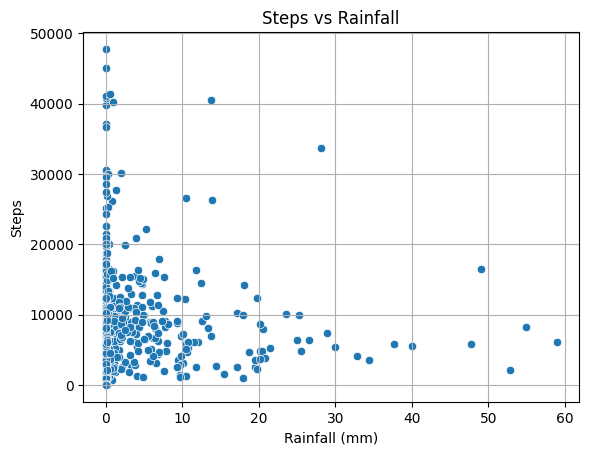

In [ ]:
## Steps vs. rainfall
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=merged, x='precip', y='value')
plt.title('Steps vs Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Steps')
plt.grid(True)
plt.show()

## No clear trend here


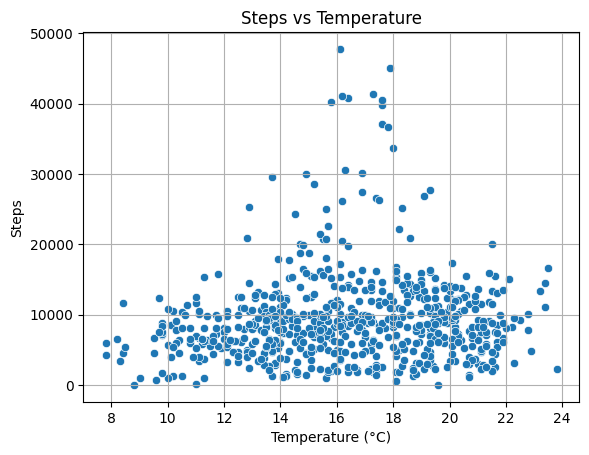

In [35]:

## Steps vs. Temp
sns.scatterplot(data=merged, x='temp', y='value')
plt.title('Steps vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Steps')
plt.grid(True)
plt.show()

In [ ]:
## Correlation
print(merged[['value', 'temp', 'precip']].corr())

## Okay this is as expected 
##  - temp positively correlated with step count e.g. more steps when it is warmer
##  - rain is negatively correlated with steps e.g. less steps when more rain.

           value      temp    precip
value   1.000000  0.096635 -0.084123
temp    0.096635  1.000000  0.053299
precip -0.084123  0.053299  1.000000


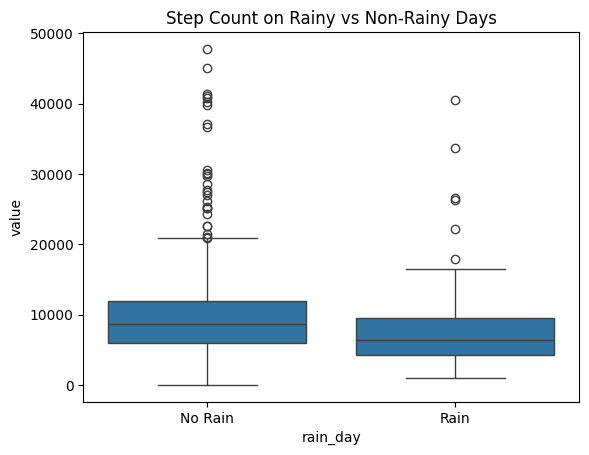

In [44]:
## Rain vs. no rain comparison

merged['rain_day'] = merged['precip'] > 5.0  # define rain threshold
sns.boxplot(data=merged, x='rain_day', y='value')
plt.xticks([0, 1], ['No Rain', 'Rain'])
plt.title('Step Count on Rainy vs Non-Rainy Days')
plt.show()

In [ ]:
## Quick linear model
import statsmodels.api as sm

X = merged[['temp', 'precip']]
X = sm.add_constant(X)  # adds intercept
y = merged['value']

model = sm.OLS(y, X).fit()
print(model.summary())

## small p-values indicate that there is significant relationship between temp, precip, step count. 

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.750
Date:                Fri, 06 Jun 2025   Prob (F-statistic):            0.00335
Time:                        21:45:05   Log-Likelihood:                -6676.0
No. Observations:                 655   AIC:                         1.336e+04
Df Residuals:                     652   BIC:                         1.337e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6505.4566   1237.099      5.259      0.0